<a href="https://colab.research.google.com/github/zhus-dika/math_home_works/blob/main/hw03_A_B_test_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://camo.githubusercontent.com/ad20aaaa48264581c46aa126919dbb72060ebd98cffe015523549b4974843ae5/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f46556c79616e6b696e2f725f70726f626162696c6974792f6d61737465722f656e645f73656d696e6172732f73656d5f362f73747564656e745f746561636865725f646973742e706e67" height="200">

# Прикладаная статистика: домашнее задание 3
</center>

> Если орел — я выиграла, если решка — ты проиграл.

$\qquad$ Рейчел из друзей


**ФИО:**


## Общая информация


__Дата выдачи:__ 24.05.2023

__Дедлайн:__ 23:59MSK 11.06.2023

# Результаты A-B теста

В данном задании вам нужно будет проанализировать АБ тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользователь совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('ab_browser_test.csv',sep=',')

df['click_per_queries'] = df['n_clicks']/df['n_queries']
df['empty_query_share'] = df['n_nonclk_queries']/df['n_queries']

print(df.shape)
df.head()

(267005, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19.0,0.718750,0.593750
1,3,Browser #4,exp,3,4,2.0,0.750000,0.500000
2,5,Browser #4,exp,29,35,16.0,0.828571,0.457143
3,6,Browser #4,control,12,6,0.0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30.0,0.794118,0.441176


Будем работать с числом кликов на количество пользовательских сессий.

> Вообще, это ratio-метрика. Из-за этого у неё будут довольно тяжёлые хвосты. Мы увидим это ниже в пункте про бутстрэп. И к ней нужен особый подход, о котором мы поговорим на лекции. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

__[10 баллов]__ Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [6]:
df_exp = df[df.slot == 'exp']
df_control = df[df.slot == 'control']

In [7]:
(df_exp.click_per_queries.sum() / df_control.click_per_queries.sum() - 1) * 100

5.380884644263917

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ АБ-теста

__[10 баллов]__ Давайте внимательнее посмотрим на то, что происходит с кликами в наших пользовательских сессиях. Постройте для контрольной и тестовой групп визуализации и ответьте на следующие вопросы.

- Правда ли, что в данных есть много выбросов?
- Правда ли, что данные пришли из одного распределения и в группах отличия только в сдвиге (для ответа на этот вопрос постройте для обеих групп квантили распределений с шагом в 0.1 и сравните их между собой + сравните гистограмы по форме)
- Как думаете, какие тесты применимы здесь для проведения АБ?

**Ответы:**

🦒 Да, действительно выбросов много, графически это можно заметить на графиках сравнения релплотов.

🦤 Да, согласно графикам для квантилей, можно увидеть небольшой сдвиг вверх для переменной `click_per_queries` в экспериментольной группе.

🪲 z-тест не подойдет, потому, что он плохо работает с данными, которые содержат много выбросов. Можно попробовать критерий Манна-Уитни.

In [13]:
df.describe()

,userID,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
count,267005.000000,267005.000000,267005.000000,267004.000000,267005.000000,267004.000000
mean,140370.612906,18.051707,16.721646,7.168020,1.075740,0.415362
std,81218.663853,25.960595,20.693874,10.391557,0.845868,0.273316
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,70043.000000,3.000000,4.000000,1.000000,0.600000,0.230769
50%,140124.000000,10.000000,10.000000,4.000000,1.000000,0.400000
75%,210669.000000,23.000000,22.000000,9.000000,1.352941,0.571429
max,281928.000000,863.000000,665.000000,581.000000,60.000000,1.000000


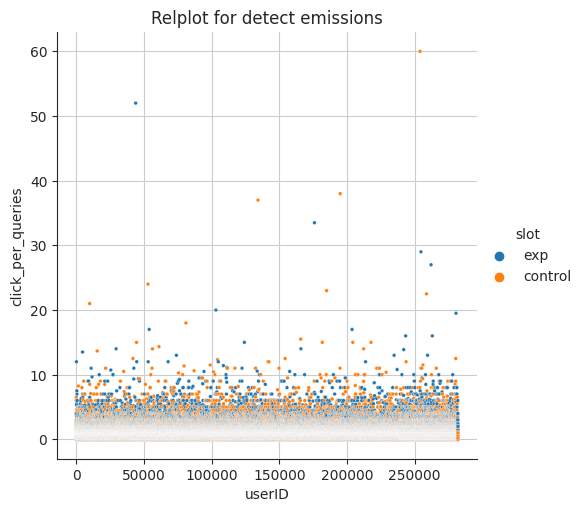

In [14]:
sns.relplot(data=df, x='userID', y='click_per_queries', hue='slot', s=7)
plt.title(f'Relplot for detect emissions')
plt.xlabel('userID')
plt.ylabel('click_per_queries')
sns.set_style("ticks",{'axes.grid' : True})

In [11]:
click_per_queries_quantiles = {'exp': [], 'control': []}

for i in range(100):
  click_per_queries_quantiles['exp'].append(df_exp.click_per_queries.quantile(0.01 * i))
  click_per_queries_quantiles['control'].append(df_control.click_per_queries.quantile(0.01 * i))

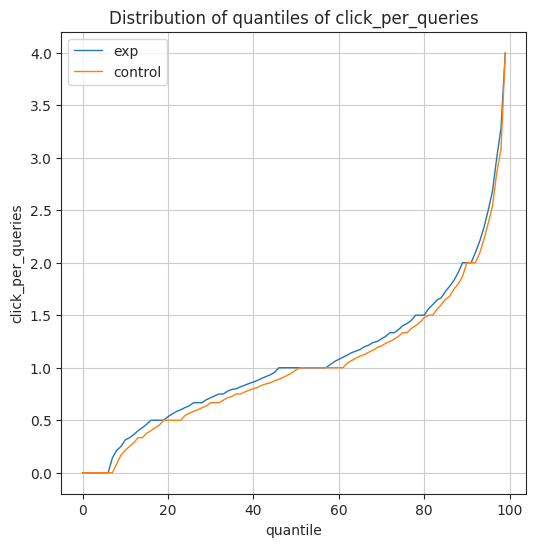

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(click_per_queries_quantiles['exp'], label="exp", linewidth=1)
ax.plot(click_per_queries_quantiles['control'], label="control", linewidth=1)
ax.legend()
plt.title(f'Distribution of quantiles of click_per_queries')
plt.xlabel('quantile')
plt.ylabel('click_per_queries')
plt.show()

__[10 баллов]__ Скорее всего, в пункте выше вы написали, что $z$-тест нам не подходит из-за выбросов. Однако, мы не можем наверняка знать, насколько серьёзное влияние эти выбросы оказали на ЦПТ и сломали ли они её. Если посчитать по выброкам средние и медианы, они окажутся очень похожими.

Бутстрап — это асимптотическая техника для получения критических значений статистики. Давайте проведём следующую процедуру. Ограничимся в рамках неё контрольной группой. Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстрэп, чтобы понять, как распределена z-статистика и сравнить её распределение с нормальным.

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не надо будет делать бутстрэп в бутстрэпе. Когда мы знаем для нашей статистики форму дисперсии, бутстрэп называется __параметрическим.__

1. Получите из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитайте среднее и его дисперсию,
3. Рассчитайте значение $z$-статистики,
4. Для получившегося вектора из $z$-статистик постройте `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.

Сделайте выводы.

In [15]:
df_exp.describe()

,userID,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
count,132874.000000,132874.000000,132874.000000,132874.000000,132874.000000,132874.000000
mean,140400.402562,18.213924,16.492655,6.893674,1.109145,0.400286
std,81185.125504,25.896140,20.322706,10.048759,0.847933,0.269331
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,70270.000000,3.000000,4.000000,1.000000,0.637931,0.214286
50%,140088.500000,10.000000,10.000000,4.000000,1.000000,0.388889
75%,210756.000000,23.000000,21.000000,9.000000,1.400000,0.555556
max,281927.000000,776.000000,665.000000,581.000000,52.000000,1.000000


In [16]:
df_control.describe()

,userID,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
count,134131.000000,134131.000000,134131.000000,134130.000000,134131.000000,134130.000000
mean,140341.102422,17.891010,16.948491,7.439797,1.042647,0.430298
std,81252.166116,26.023389,21.052734,10.713455,0.842514,0.276399
min,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,69846.000000,3.000000,4.000000,1.000000,0.566667,0.250000
50%,140148.000000,9.000000,10.000000,4.000000,0.980769,0.416667
75%,210581.500000,23.000000,22.000000,10.000000,1.333333,0.600000
max,281928.000000,863.000000,435.000000,386.000000,60.000000,1.000000


In [17]:
def get_bootstrap_sample(x, B_sample=1):
  n = x.size
  sample = np.random.choice(x, size=(n, B_sample), replace=True)
  if B_sample == 1:
    sample = sample.T[0]
  return sample

In [28]:
n_boot_samples = 1000
exp_boot = get_bootstrap_sample(df_exp.click_per_queries, B_sample=n_boot_samples)
mean_exp_boot = np.mean(exp_boot, axis=0)
std_exp_boot = np.std(exp_boot, axis=0)


control_boot = get_bootstrap_sample(df_control.click_per_queries, B_sample=n_boot_samples)
mean_control_boot = np.mean(control_boot, axis=0)
std_control_boot = np.std(control_boot, axis=0)

In [29]:
def stat_intervals(boot, alpha=0.05):
  left = np.quantile(boot, alpha / 2)
  right = np.quantile(boot, 1 - alpha / 2)
  return left, right

In [30]:
stat_intervals(mean_exp_boot)

(1.1049591522755102, 1.113929963807285)

In [31]:
stat_intervals(mean_control_boot)

(1.038019222584916, 1.047263082999721)

In [48]:
stat_intervals(mean_exp_boot - mean_control_boot)

(0.060289415791483156, 0.07292846569506406)

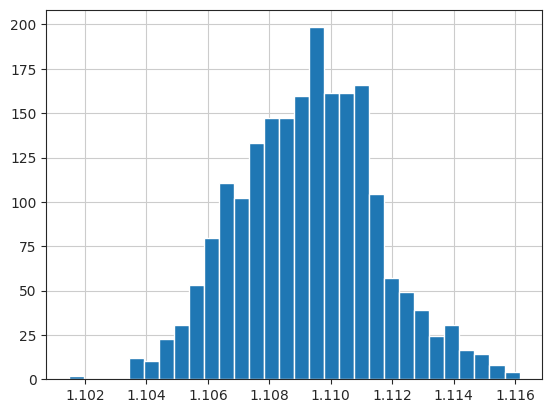

In [41]:
plt.hist(mean_exp_boot, bins=30, density=True);

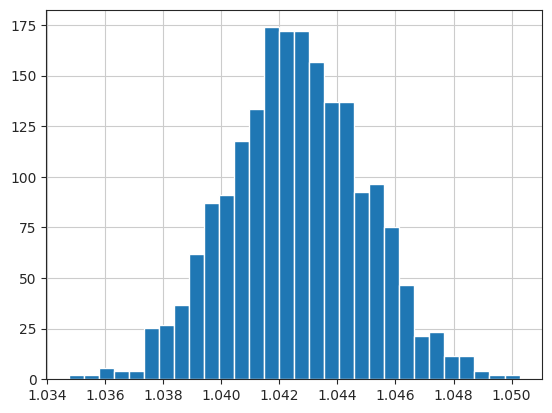

In [42]:
plt.hist(mean_control_boot, bins=30, density=True);

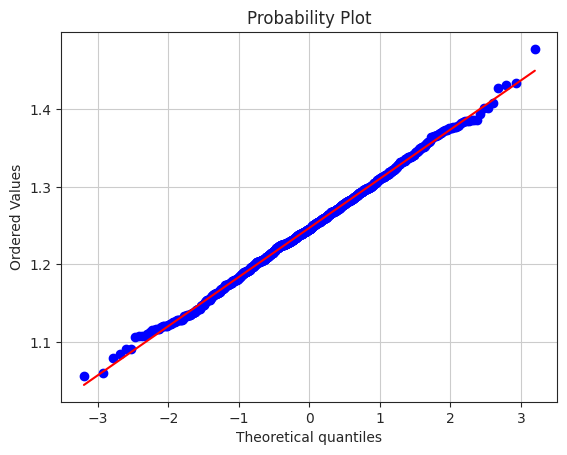

In [47]:
zstat = (mean_exp_boot - mean_control_boot) / ((std_exp_boot + std_control_boot) / np.sqrt(n_boot_samples))
sts.probplot(zstat, plot=plt);

__[10 баллов]__ Осторожно, спойлеры! В прошлом пункте у вас получилась картинка, на которой хвосты распределения немного отличаются от стандартного нормального. Давайте сделаем вид, что всё хорошо и отличия на хвостах нет. Проверьте гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

In [59]:
from statsmodels.stats.weightstats import ztest,zconfint

X = df_exp.click_per_queries
Y = df_control.click_per_queries
left, right = zconfint(X, Y, alpha=0.01)
print('conf interval:', left, right)
stat, pvalue = ztest(X, Y)
print('zstat:',stat, '\npvalue:',pvalue)

conf interval: 0.058071197066068475 0.07492467720106952
zstat: 20.326642773141288 
pvalue: 7.474488489885518e-92


🐫 Гипотеза отвергается, потому что `pvalue` < 0.01.

__[10 баллов]__ Давайте попробуем понять, какими при таких объёмах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но не мы его готовили... При решении этого пункта выберите какое-то адекватное значение MDE и получите отталкиваясь от него ошибку второго рода.

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [ ]:
# ваш код

__[10 баллов]__ Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ.

Проверьте гипотезу с помощью бутстрапа! Воспользуйтесь следующим алгоритмом с лекции:

1. Посчитайте наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создайте две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвинет обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы.
3. Сбутстрапируйте выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитайте значение z-статистики. Повторите процедуру $B$ раз.
4. Для оценки `p-value` воспользуйтесь формулой:

$$
2 * \frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [ ]:
# ваш код

__Ответьте на следующие вопросы:__

- Изменились ли выводы АБ-теста?
- Насколько сильно критическое значение статистики, полученной с помощью бутстрэпа, отличается от киритческого значения нормального распределения?
- Какую из ошибок (1 рода/2 рода) вы будете чаще совершать, если в ситуации с толстыми хвостами будете пользоваться нормальным распределением? Насколько чаще будет возникать эта ошибка?

__[10 баллов]__ Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? Для ответа на этот вопрос подставьте критические значение из бустрап-распределения в формулу для оценки числа наблюдений. В качестве MDE возьмите величину, которую вы сами зафикисировали в прошлых пунктах. В качестве ошибки второго рода возьмите получившуюся при рассчётах величину.

In [ ]:
# ваш код

__[10 баллов]__ Проверьте ту же гипотезу тестом Манна-Уитни. Используйте для этого функцию `scipy.stats.mannwhitneyu`.

In [ ]:
# ваш код

При $n,m \to \infty$ статистика Манна-Уитни сходится к нормальному распределению со следующими параметрами:

$$
U \Rightarrow N \left( \frac{n_T \cdot n_C}{2}, \frac{n_T \cdot n_C \cdot (n_T + n_C + 1)}{12} \right)
$$

Отталкиваясь от этого приближения, определите сколько наблюдений нам необходимо для проверки гипотезы для тех же MDE и ошибки 2 рода, что и у z-теста/бустрапа.

In [ ]:
# ваш код

__[10 баллов]__ У многих аналитиков с теста Манна-Уитни подгорает жепа. Это происходит из-за того, что на практике его часто используют довольно бездумно. [Вот один из свежих примеров бомбежа.](https://habr.com/ru/companies/avito/articles/709596/)

В нашем кейсе, если аккуратно посчитать квантили обоих распределений, можно увидеть, что в тестовой группе квантили и правда съехали вправо, а форма гистограмм не изменилась. В целом, это знак, что тест можно спокойно применять. Однако, квантили левее $0.1$ не поменялись.

Вместо тесто Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверьте гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [ ]:
# ваш код

Насколько сильно друг от друга отличаются p-значения этих тестов? Как думаете, почему отличие именно такое?

__Ответ:__

## Часть 2: CUPED

Попробуем натянуть сову на глобус. Давайте сделаем вид, что на самом деле первые $50\%$ таблицы это выборка, которая у нас была до эксперимента. Попробуем провернуть CUPED.

__[10 баллов]__ рассчитайте значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [ ]:
# ваш код

__[20 баллов]__ теперь проверните CUPED. Используйте значение целевой переменной из первой части выборки как ковариату.

Для оценки линейных моделей используйте пакет `statsmodels`. Пример того, как это можно делать [есть тут.](https://github.com/FUlyankin/matstat-AB/blob/main/week13_linreg/11_python_regression.ipynb) Предполагайте, что в данных есть гетероскедастичность. Для её фикса пользуйтесь `HC-3`.

Насколько у нас получилось уменьшить стандартную ошибку?

In [ ]:
# ваш код

__[20 баллов]__ Ровно по той же схеме проверните CUPAC. В качестве базовой модели возьмите какой-нибудь градиентный бустинг. Насколько у нас получилось уменьшить стандартную ошибку?

In [ ]:
# ваш код

__[10 баллов]__ Финальный вопрос! А как использовать эту новую стандартную ошибку в формуле для рассчёта числа наблюдений? Выясните при выбранном выми MDE, какая у нас будет ошибка второго рода в CUPED и CUPAC, если в АБ-тесте будет участвовать только половина наблюдений.

In [ ]:
# ваш код